In [1]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
import warnings
import itertools

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['backend'] = 'SVG'

# 黄金预测参数的选择

In [3]:
df = pd.read_excel('E:/论文/论文2/数据/表.xlsx',index_col=0)
df.reset_index(inplace=True)
df.head()

,Date,USD (PM),Value,DealDay,黄金涨幅(%),比特币涨幅(%),黄金5日均价,黄金5日乖离率,比特币5日均价,比特币5日乖离率,...,黄金涨幅的前90日均值,黄金5日乖离率的前90日均值,黄金牛市,gold_cow,比特币涨幅的前30日均值,比特币5日乖离率的前30日均值,比特币牛市,bt_cow,黄金购买风险,比特币购买风险
0,2016-09-11,0.00,621.65,0,0.493311,0.641569,0.0,0.460623,0.000000,0.550392,...,NaN,NaN,0.494444,-1,NaN,NaN,0.483333,-1,0.492608,0.485020
1,2016-09-12,1324.60,609.67,1,0.493311,0.609981,0.0,0.460623,0.000000,0.550392,...,NaN,NaN,0.488889,-2,NaN,NaN,0.466667,-2,0.487354,0.468772
2,2016-09-13,1323.65,610.92,1,0.486412,0.644930,0.0,0.460623,0.000000,0.550392,...,NaN,NaN,0.483333,-3,NaN,NaN,0.450000,-3,0.482100,0.452525
3,2016-09-14,1321.75,608.82,1,0.479503,0.635935,0.0,0.460623,0.000000,0.550392,...,NaN,NaN,0.477778,-4,NaN,NaN,0.433333,-4,0.476846,0.436278
4,2016-09-15,1310.80,610.38,1,0.413621,0.645769,0.0,0.460623,0.009834,0.545356,...,NaN,NaN,0.472222,-5,NaN,NaN,0.416667,-5,0.471592,0.419903


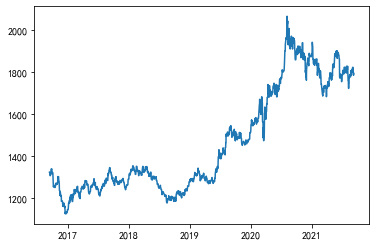

In [4]:
plt.plot(df['Date'][1:],df['USD (PM)'][1:])
plt.savefig('黄金走势图.png')
plt.show()

In [5]:
data = df['USD (PM)'][df['DealDay']==1].copy()
# data = df['USD (PM)'][1:].copy()
data_diff=data
data_diff.index=df['Date'][df['DealDay']==1].copy()
# data_diff.index=df['Date'][1:].copy()
data_diff=data_diff.diff(1).dropna()
diff_df = pd.DataFrame()
diff_df['diff_1'] =  data_diff
diff_df['diff_2'] = data_diff.diff(1).dropna()
diff_df['diff_3'] = diff_df['diff_2'].diff(1).dropna()

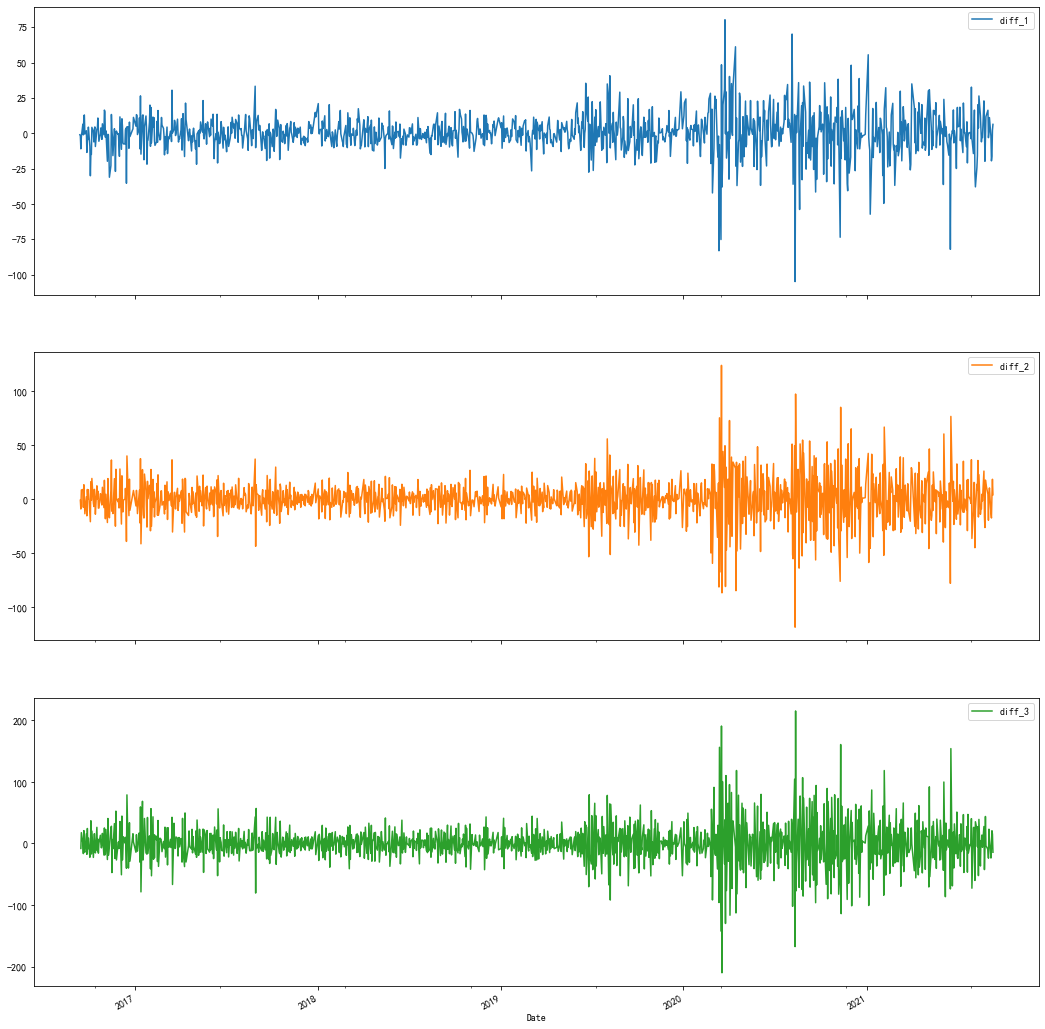

In [6]:
diff_df.plot(subplots=True,figsize=(18,20))
plt.savefig('黄金差分对比图.png')
plt.show()
# 对比选择几阶差分,肉眼观察数据平稳性

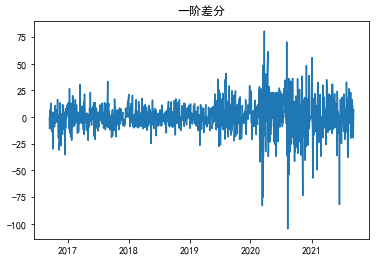

In [7]:
plt.plot(data_diff)
plt.title('一阶差分')
plt.savefig('黄金一节差分图.png')
plt.show()

adfuller单位根检验数据平稳性  
输出结果中：  
第一个是adt检验的结果，简称为T值，表示t统计量。  
第二个简称为p值，表示t统计量对应的概率值。  
第三个表示延迟。  
第四个表示测试的次数。  
第五个是配合第一个一起看的，是在99%，95%，90%置信区间下的临界的ADF检验的值。  

第一点，1%、5%、10%不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设。  
第二点，p值要求小于给定的显著水平，p值要小于0.05，等于0是最好的。
ADF检验的原假设是存在单位根，只要这个统计值是小于1%水平下的数字就可以极显著的拒绝原假设，认为数据平稳。注意，ADF值一般是负的，也有正的，但是它只有小于1%水平下的才能认为是及其显著的拒绝原假设。  
（原假设为不是平稳时间序列)

In [8]:
print(adfuller(data))  # 原始数据
print(adfuller(diff_df['diff_1'].dropna()))  # 一阶差分
print(adfuller(diff_df['diff_2'].dropna()))  # 二阶差分
print(adfuller(diff_df['diff_3'].dropna()))  # 三阶差分

(-0.43415247222844455, 0.9042384812941657, 23, 1231, {'1%': -3.435673305025808, '5%': -2.863890744031555, '10%': -2.56802156936202}, 9957.827619599739)
(-8.158681091879233, 9.26971142153686e-13, 22, 1231, {'1%': -3.435673305025808, '5%': -2.863890744031555, '10%': -2.56802156936202}, 9948.53365765105)
(-12.87677688696717, 4.7509719563347765e-24, 23, 1229, {'1%': -3.4356819860439574, '5%': -2.863894574114006, '10%': -2.568023609111511}, 9993.29712959746)
(-15.44354192899521, 2.8443744636804176e-28, 23, 1228, {'1%': -3.4356863371792095, '5%': -2.8638964938393667, '10%': -2.568024631481501}, 10131.54664311088)


原始数据的P值>0.05所以不满足平稳性要求  
一阶差分的P值<0.05，且T值小于1%，5%，10%下的统计值，可以极显著的拒绝原假设，说明数据是平稳的。  
一阶差分数据已经平稳就无需继续做二阶差分了。  

In [9]:
acorr_ljungbox(data_diff, lags = 20)

(array([ 0.6383532 ,  3.17621996,  3.61984998, 22.55361156, 25.13623913,
        34.62843027, 39.55951281, 40.41153736, 41.46739023, 42.35820761,
        42.42976253, 46.84668541, 47.34607255, 48.1027663 , 49.38707288,
        49.39206838, 54.57334394, 54.57477088, 54.68152319, 54.78047638]),
 array([4.24307759e-01, 2.04311400e-01, 3.05547403e-01, 1.55464367e-04,
        1.31142270e-04, 5.08594224e-06, 1.52825905e-06, 2.68494347e-06,
        4.11136308e-06, 6.47429424e-06, 1.36446371e-05, 4.95539451e-06,
        8.44485028e-06, 1.26405982e-05, 1.51571768e-05, 2.86385753e-05,
        8.02136606e-06, 1.49259996e-05, 2.60027199e-05, 4.42803246e-05]))

acorr_ljungbox输出结果的第二项为基于卡方分布的p统计量，一阶差分的P值都很小，所以该数据拒绝原假设，即认为该数据不是纯随机数据  
不是纯随机数才可以做时间序列分析

# 观察法选择p,q
|模型|ACF|PACF|
|-|-|-|
|AR(p)|衰减趋于零(几何型或振荡型)|p阶后截尾|
|MA(q)|q阶后截尾|衰减趋于零(几何型或振荡型)|
|ARMA(p,q)|q阶后衰减趋于零(几何型或振荡型)|p阶后衰减趋于零(几何型或振荡型)|

截尾:落在置信区间内( 95%的点都符合该规则)

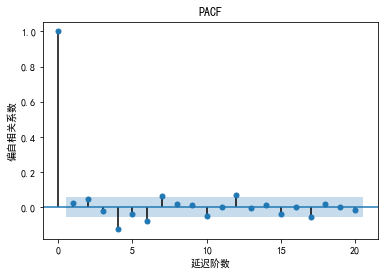

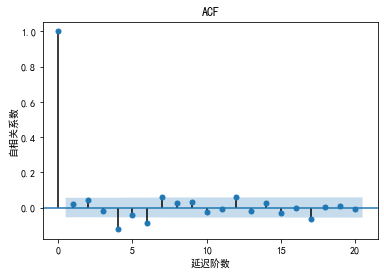

In [10]:
pacf = plot_pacf(data_diff, lags=20)
plt.xlabel("延迟阶数")
plt.ylabel("偏自相关系数")
plt.title('PACF')
plt.savefig('E:/论文/论文2/论文图片/图3黄金的PACF图.svg',format='svg')
pacf.show()

acf = plot_acf(data_diff, lags=20)
plt.xlabel("延迟阶数")
plt.ylabel("自相关系数")
plt.title('ACF')
plt.savefig('E:/论文/论文2/论文图片/图2黄金的ACF图.svg',format='svg')
acf.show()

# 穷举法选择最好的p,q
max_ar和max_ma为最大可取参数，数值较大时运行结果较长。建议为5

In [11]:
#import statsmodels.tsa.stattools as st
#model = st.arma_order_select_ic(data_diff, max_ar=6, max_ma=6, ic=['aic', 'bic', 'hqic'])
#print(model.bic_min_order)
#print(model.aic_min_order)
# 结果为(p,q)

训练ARIMA模型  
order参数里的三个值分别为（p,d阶差分,q）  
对于使用穷举法得出结果为0,0,且绘制出的图形效果较差时，可以根据肉眼观察图主动选择

In [12]:
"""for p in [4,6,12]:
    for q in [4,6,12]:
        #model = ARIMA(data, order=(4,1,4))
        model = SARIMAX(data, order=(p,1,q),seasonal_order=(0,0,0,1))
        result = model.fit()
        resid = result.resid
        print('p:',p, '\tq:',q, '\taic:',result.aic, '\tbic:',result.bic,
             '\tDW:',sm.stats.durbin_watson(resid.values))"""

"for p in [4,6,12]:\n    for q in [4,6,12]:\n        #model = ARIMA(data, order=(4,1,4))\n        model = SARIMAX(data, order=(p,1,q),seasonal_order=(0,0,0,1))\n        result = model.fit()\n        resid = result.resid\n        print('p:',p, '\tq:',q, '\taic:',result.aic, '\tbic:',result.bic,\n             '\tDW:',sm.stats.durbin_watson(resid.values))"

# 季节性分解

In [13]:
#数据平稳性检测 因为只有平稳数据才能做时间序列分析
def judge_stationarity(data_sanya_one):
    dftest = adfuller(data_sanya_one)
    print(dftest)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    stationarity = 1
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value 
        if dftest[0] > value:
                stationarity = 0
    print(dfoutput)
    print("是否平稳(1/0): %d" %(stationarity))
    return stationarity

## 乘法分解

In [14]:
#decomposition = seasonal_decompose(data,freq=4)
#decomposition = seasonal_decompose(data, model='multiplicative', extrapolate_trend='freq', freq=72)  
#trend = decomposition.trend
#seasonal = decomposition.seasonal
#residual = decomposition.resid

In [15]:
#plt.figure(figsize=(15, 7))
#decomposition.plot()
#plt.show()

In [16]:
#print("test: p={}".format(adfuller(seasonal)[1]))
#print('残差的均值:',residual.mean())

In [17]:
#季节平稳性检测
#stationarity = judge_stationarity(residual)

## 加法分解

In [18]:
#decomposition = seasonal_decompose(data, model='additive', extrapolate_trend='freq', freq=72)  
#trend = decomposition.trend
#seasonal = decomposition.seasonal
#residual = decomposition.resid

In [19]:
#plt.figure(figsize=(15, 7))
#decomposition.plot()
#plt.show()

In [20]:
#print("test: p={}".format(adfuller(seasonal)[1]))
#print('残差的均值:',residual.mean())

In [21]:
#季节平稳性检测
#stationarity = judge_stationarity(residual)

# 通过网格搜索对seasonal_order进行定阶,目前就是pdq=6,1,6，seasonal_order=2, 2, 2, 52效果比较好，AIC=8837

In [22]:
def get_ARIMA_params(data, pdq, m=12):
    p = d = q = range(1, 3)
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data,
                                        order=pdq,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
        if results.aic < score_aic:
            score_aic = results.aic
            params = param_seasonal, results.aic
    param_seasonal, results.aic = params
    print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
    return param_seasonal

In [23]:
#pdq = [6, 1, 6]
#get_ARIMA_params(data, pdq, m=52)

季节性分解的参数（SARIMAX）

In [24]:
model = SARIMAX(data, order=(6,1,6))
result = model.fit()

残差检验  
如果残差是白噪声序列，说明时间序列中有用的信息已经被提取完毕了，剩下的全是随机扰动，是无法预测和使用的。  
qq图中：如果是正态分布则为一条直线，即红线。结果大致符合白噪声

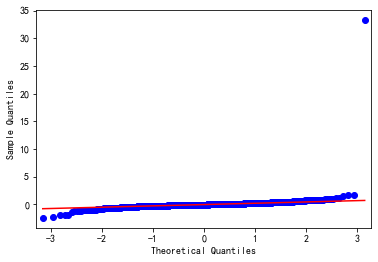

In [25]:
resid = result.resid

qqplot(resid, line='q', fit=True)
#plt.savefig('黄金arima残差QQ图.png')
plt.show()

Durbin-Watson 检验，又称 DW 检验，是用来检验回归分析中残差的一阶自相关性的(尤其针对时间序列数据)。  
该统计量值越接近 2 越好，一般在 1~3 之间说明没问题，小于 1 这说明残差存在自相关性

In [26]:
print(sm.stats.durbin_watson(resid.values))

1.120835610297245


In [27]:
# result.summary()

预测  
predict(起始时间，终止时间)，预测出的结果为黄金的价格

In [28]:
pred = result.predict('2016-09-20','2021-9-10')
# pred = result.predict(1,1655)
print(len(pred))
print(pred[-10:])

1249
Date
2021-08-27    1782.919240
2021-08-31    1799.026132
2021-09-01    1817.688056
2021-09-02    1814.160175
2021-09-03    1812.662843
2021-09-06    1818.881424
2021-09-07    1820.918725
2021-09-08    1800.521515
2021-09-09    1787.379690
2021-09-10    1786.871682
dtype: float64


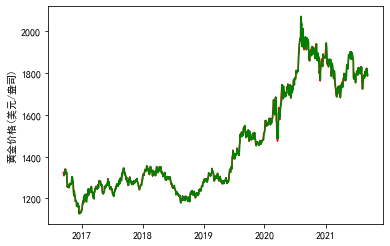

In [29]:
plt.plot(data,c='r')
plt.plot(pred,c='g')
plt.ylabel("黄金价格(美元/盎司)")
plt.savefig('E:/论文/论文2/论文图片/图7黄金价格预测的结果.svg',format='svg')
plt.show()